In [ ]:
!nvidia-smi

Thu Mar 25 10:56:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import io
import os
import sys
import gc
import pickle
import random
import termcolor
import warnings
import shutil
import math
from functools import partial
from datetime import datetime
from dataclasses import dataclass
from pathlib import Path
from typing import List

import pandas as pd
import numpy as np
from tqdm.auto import tqdm

from scipy.special import softmax

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

import more_itertools 

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Sampler

In [ ]:
!pip uninstall -y torchtext

Uninstalling torchtext-0.9.0:
  Successfully uninstalled torchtext-0.9.0


In [ ]:
!pip install -q pytorch-lightning
!pip install -q transformers
!pip install -q datasets

     |████████████████████████████████| 829kB 7.4MB/s 
     |████████████████████████████████| 112kB 25.1MB/s 
     |████████████████████████████████| 184kB 17.9MB/s 
     |████████████████████████████████| 276kB 11.7MB/s 
     |████████████████████████████████| 829kB 21.6MB/s 
     |████████████████████████████████| 1.3MB 37.1MB/s 
     |████████████████████████████████| 143kB 26.1MB/s 
     |████████████████████████████████| 296kB 58.2MB/s 
     |████████████████████████████████| 2.0MB 10.0MB/s 
     |████████████████████████████████| 3.2MB 56.0MB/s 
     |████████████████████████████████| 890kB 56.7MB/s 
     |████████████████████████████████| 194kB 7.5MB/s 
     |████████████████████████████████| 245kB 11.6MB/s 


In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.loggers.csv_logs import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.metrics.classification import Accuracy
from pytorch_lightning.core.decorators import auto_move_data
from pytorch_lightning.loggers import NeptuneLogger

import datasets
from datasets import Dataset

from transformers import (
    AutoModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup,
    AutoModelForMaskedLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling
)

In [ ]:
pl.__version__

'1.2.5'

# Config

In [ ]:
DEBUG = True
SAVE_PATH = None
SEED = 42
NOW = datetime.strftime(datetime.now() , "%m%d")

SAVE_PATH = Path(f'/content/lightning-logs/')
SAVE_PATH.mkdir(exist_ok=True)

NUM_WORKERS = os.cpu_count()
GPUS = 1 if torch.cuda.is_available() else None

print("DEBUG:\t", DEBUG)
print("SAVE_PATH:\t", SAVE_PATH)
print("NUM_WORKERS:\t", NUM_WORKERS)
print("GPUS:\t", GPUS)

DEBUG:	 True
SAVE_PATH:	 /content/lightning-logs
NUM_WORKERS:	 2
GPUS:	 1


In [ ]:
@dataclass
class Config:
    model_name:str = 'bert-base-uncased'
    max_seq_len:int = 192
    num_fold:int = 5

    lr:float = 3e-5
    batch_size: int = 32
    num_epoch:int = 4
    max_grad_norm:float = 1.0
    gradient_accumulation_steps: int = 1
    warmup_steps: int = 0
    weight_decay: float = 0.0
    adam_beta1: float = 0.9
    adam_beta2: float = 0.999
    adam_epsilon: float= 1e-8
    max_grad_norm: float = 1.0

    save_top_k:int = 1

    def __post_init__(self):
        pass


cfg = Config()
cfg

Config(model_name='bert-base-uncased', max_seq_len=192, num_fold=5, lr=3e-05, batch_size=32, num_epoch=4, max_grad_norm=1.0, gradient_accumulation_steps=1, warmup_steps=0, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, save_top_k=1)

Setup tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(cfg.model_name)

# Helper

In [ ]:
def save_pkl(dir, name, obj):
    dir.mkdir(exist_ok=True)
    with open(dir / name, 'wb') as f:
        pickle.dump(obj, f)

def load_pkl(dir, name):
    with open(dir / name, 'rb') as f:
        return pickle.load(f)

In [ ]:
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)

# Load Data

In [ ]:
train_df = pd.read_csv("../input/Train.csv")
test_df = pd.read_csv("../input/Test.csv")

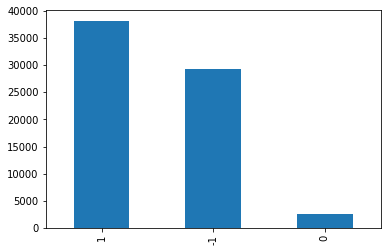

In [ ]:
train_df['label'].value_counts().plot(kind='bar')

In [ ]:
LABEL2ID = {label:i for i, label in enumerate(train_df['label'].unique())}
ID2LABEL = {v:k for k, v in LABEL2ID.items()}

train_df['label_ids'] = train_df['label'].map(LABEL2ID)

# Domain Adaptation

In [ ]:
all_df = pd.concat([train_df[['text']], test_df[['text']]], axis=0)

In [ ]:
block_size = 128
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
        # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
lm_dataset = Dataset.from_pandas(all_df)
lm_dataset.remove_columns_(column_names=['__index_level_0__'])

remove_columns_ is deprecated and will be removed in the next major version of datasets. Use the dataset.remove_columns method instead.


In [ ]:
lm_dataset = lm_dataset.map(lambda x: tokenizer(x['text']), remove_columns=['text'], batched=True, num_proc=NUM_WORKERS)

Token indices sequence length is longer than the specified maximum sequence length for this model (534 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (861 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
lm_dataset = lm_dataset.map(
    group_texts,
    batched=True,
    batch_size=1000,
    num_proc=4,
)

In [ ]:
lm_dataset = lm_dataset.train_test_split(seed=SEED, train_size=0.99)

In [ ]:
lm_model = AutoModelForMaskedLM.from_pretrained(cfg.model_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
lm_data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

In [ ]:
training_args = TrainingArguments(
    output_dir="/content/tunizi-bert",
    evaluation_strategy = "epoch",
    # learning_rate=2e-5,
    # weight_decay=0.01,
    save_total_limit=1,
    num_train_epochs=3,
    fp16=True
)

In [ ]:
trainer = Trainer(
    model=lm_model,
    args=training_args,
    train_dataset=lm_dataset["train"],
    eval_dataset=lm_dataset["test"],
    data_collator=lm_data_collator,
)

In [ ]:
eval_results = trainer.evaluate()

In [ ]:
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

Perplexity: 406.19


In [ ]:
%%time
trainer.train()

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch,Training Loss,Validation Loss,Runtime,Samples Per Second
1,3.428900,3.227975,1.067100,188.362000
2,3.077600,2.904176,1.072900,187.350000
3,2.941200,2.822728,1.065600,188.632000


CPU times: user 15min 5s, sys: 6min 20s, total: 21min 25s
Wall time: 22min


TrainOutput(global_step=7431, training_loss=3.2597271197096624, metrics={'train_runtime': 1320.4692, 'train_samples_per_second': 5.628, 'total_flos': 4998477872747520.0, 'epoch': 3.0, 'train_mem_cpu_alloc_delta': 1082593, 'train_mem_gpu_alloc_delta': 1359354880, 'train_mem_cpu_peaked_delta': 95687499, 'train_mem_gpu_peaked_delta': 1333629440})

In [ ]:
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

Perplexity: 18.42


In [ ]:
lm_model.save_pretrained('/content/tunizi-bert/last')

In [ ]:
del all_df, trainer, lm_dataset, lm_model, lm_data_collator
gc.collect()

50

# Dataset Module

In [ ]:
def encode(tokenizer, text, max_seq_length=512, padding=False, mask_padding_with_zero=True):
    tokens = tokenizer.tokenize(text)

    # truncation
    # for [CLS] + [SEP]
    if len(tokens) > max_seq_length - 2:
        half = max_seq_length // 2
        head = tokens[:(half-1)]
        tail = tokens[-(half-1):]

        tokens = head + tail
        assert len(tokens) == max_seq_length - 2

    # [HEAD + TAIL] + [SEP]
    tokens += [tokenizer.sep_token]
    # [CLS] + [HEAD + TAIL] + [SEP]
    tokens = [tokenizer.cls_token] + tokens
    # to ids
    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # make attention mask ids
    input_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

    if padding:
    # padding 
        padding_length = max_seq_length - len(input_ids)
        input_ids += [tokenizer.pad_token_id] * padding_length
        input_mask += [0 if mask_padding_with_zero else 1] * padding_length

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length

    return {
        'input_ids': np.array(input_ids, dtype=int),
        'attention_mask': np.array(input_mask, dtype=int),
    }

encode_func = partial(encode, tokenizer=tokenizer, max_seq_length=cfg.max_seq_len)

In [ ]:
def prepare_dataset(df, text_column, encode_func, is_test=False):
    ds = Dataset.from_pandas(df)

    # ここでmapでtokenizerを行っておく
    # encode_func内でtrucnateなどを内部で実行する
    # on the fly の場合はここではできない
    if not is_test:
        ds = ds.map(lambda ex: encode_func(text=ex[text_column]))
        ds = ds.map(lambda x: {'input_len':len(x['input_ids'])})
    
    else:
        ds = ds.map(lambda ex: encode_func(text=ex[text_column]))
        ds = ds.map(lambda x: {'input_len':len(x['input_ids'])})
        # ds.set_format("torch", columns=["input_ids", "attention_mask"])


    return ds

In [ ]:
def sliding_window(example):
    sliding_examples = []

    id = example['ID']
    input_ids = example['input_ids']

    windows = list(more_itertools.windowed(input_ids, 96 - 2, step=64, fillvalue=None))

    for window in windows:
        window = [input_id for input_id in window if input_id is not None]

        sliding_example = {}
        sliding_example['ID'] = id

        if window[0] == tokenizer.cls_token_id:
            sliding_example['input_ids'] = window
        else:
            sliding_example['input_ids'] = [tokenizer.cls_token_id]
            sliding_example['input_ids'] += window

        if window[-1] != tokenizer.sep_token_id:
            sliding_example['input_ids'] += [tokenizer.sep_token_id]

        input_mask = [1] * len(sliding_example['input_ids'])

        sliding_example['attention_mask'] = input_mask

        assert len(sliding_example['input_ids']) == len(sliding_example['attention_mask'])

        sliding_examples.append(sliding_example)

    return sliding_examples

In [ ]:
train_ds = prepare_dataset(train_df, text_column='text', encode_func=encode_func, is_test=False)

Token indices sequence length is longer than the specified maximum sequence length for this model (532 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
test_ds = prepare_dataset(test_df, text_column='text', encode_func=encode_func, is_test=True)
test_ds.set_format('numpy', columns=['input_ids', 'attention_mask'])

In [ ]:
def batch_ordering(ds, cfg):
    train_samples = []

    for item in tqdm(ds):
        train_samples.append(item)

    batch_orderd_samples = []
    while len(train_samples) > 0:
        to_take = min(cfg.batch_size, len(train_samples))

        select = random.randint(0, len(train_samples) - to_take)

        batch = train_samples[select: (select + to_take)]

        batch_orderd_samples.extend(batch)

        del train_samples[select:select + to_take]

    ds = Dataset.from_pandas(pd.DataFrame(batch_orderd_samples))

    return ds

In [ ]:
train_ds = train_ds.sort("input_len")

In [ ]:
train_ds = batch_ordering(train_ds, cfg)

In [ ]:
def pad_sequences(seqs):
    lens = [len(seq) for seq in seqs]
    max_len = max(lens)

    # 最初にPADDINGの配列用意
    padded_seqs = torch.zeros(len(seqs), max_len).long()
    for i, seq in enumerate(seqs):
        start = max_len - lens[i]
        padded_seqs[i, :lens[i]] = torch.LongTensor(seq)
    return padded_seqs

In [ ]:
def default_data_collator(features):
    """
    Very simple data collator that simply collates batches of dict-like objects and performs special handling for
    potential keys named:
        - ``label``: handles a single value (int or float) per object
        - ``label_ids``: handles a list of values per object
    Does not do any additional preprocessing: property names of the input object will be used as corresponding inputs
    to the model. See glue and ner for example of how it's useful.
    """

    first = features[0]
    batch = {}

    # Special handling for labels.
    # Ensure that tensor is created with the correct type
    # (it should be automatically the case, but let's make sure of it.)
    if "label" in first and first["label"] is not None:
        label = first["label"].item() if isinstance(first["label"], torch.Tensor) else first["label"]
        dtype = torch.long if isinstance(label, int) else torch.float
        batch["labels"] = torch.tensor([f["label"] for f in features], dtype=dtype)
    elif "label_ids" in first and first["label_ids"] is not None:
        if isinstance(first["label_ids"], torch.Tensor):
            batch["labels"] = torch.stack([f["label_ids"] for f in features])
        else:
            dtype = torch.long if type(first["label_ids"][0]) is int else torch.float
            batch["labels"] = torch.tensor([f["label_ids"] for f in features], dtype=dtype)

    if "ID" in first:
        batch["ID"] = np.array([f["ID"] for f in features])

    # Handling of all other possible keys.
    # Again, we will use the first element to figure out which key/values are not None for this model.
    for k, v in first.items():
        if k not in ("label", "label_ids") and v is not None and not isinstance(v, str):
            if isinstance(v, torch.Tensor):
                batch[k] = pad_sequences([f[k] for f in features])
            else:
                batch[k] = pad_sequences([f[k] for f in features])

    return batch

In [ ]:
class DataModule(pl.LightningDataModule):
    def __init__(self, trn_ds, val_ds, batch_size, num_workers, collate_fn, val_batch_size=None):
        super().__init__()
        self._trn_ds = trn_ds
        self._val_ds = val_ds

        self._trn_ds.set_format("torch", columns=["input_ids", "attention_mask", 'label_ids'])
        self._val_ds.set_format("torch", columns=["input_ids", "attention_mask", 'label_ids'])

        self.batch_size = batch_size
        if val_batch_size is None:
            self.val_batch_size = self.batch_size

        self.num_workers = num_workers
        self.collate_fn = collate_fn

    def train_dataloader(self) -> DataLoader:
        return DataLoader(
            self._trn_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True,
            collate_fn=self.collate_fn,
            shuffle=False,
        )

    def val_dataloader(self) -> DataLoader:
        return DataLoader(
            self._val_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True,
            collate_fn=self.collate_fn,
            shuffle=False,
        )

# Make CV

In [ ]:
cv = list(StratifiedKFold(n_splits=cfg.num_fold).split(train_ds, train_ds['label']))

In [ ]:
datamodule = DataModule(
    trn_ds = train_ds.select(cv[0][0]),
    val_ds = train_ds.select(cv[0][1]),
    batch_size = 4,
    num_workers = 1,
    collate_fn = default_data_collator,
)

In [ ]:
for item in datamodule.train_dataloader():
    break

In [ ]:
item

{'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 'input_ids': tensor([[  101, 10958,  5638, 10930,  6238,  2532,  9617,  5003,  2509,  2213,
           3089, 22827,  1056, 17883,  3501,  2102, 10882,  2232,  6053, 11795,
          14074,  3501, 25933, 24524,  2863,  2509, 11463,  1017,  8270,  6300,
           2581,  3211,  2860, 12005, 10882,  2232,  3347,  7507, 24404, 12638,
            102],
         [  101, 12323,  2094, 14841,  8405,  2072, 2

# Model

In [ ]:
class MulithSampleDropoutHead(nn.Module):
    def __init__(self, hidden_dim, out, dropout=0.5, num=5):
        super().__init__()
        
        self.num = num
        self.dropout = nn.Dropout(dropout)
        self.head = nn.Linear(hidden_dim, out)

        nn.init.normal_(self.head.weight, std=0.02)
        nn.init.normal_(self.head.bias, 0)
        
    def forward(self, x):
        x = torch.stack([self.head(self.dropout(x)) for _ in range(self.num)], dim=0)
        x = torch.mean(x, dim=0)
        
        return x

In [ ]:
class TransformerClassifier(nn.Module):
    def __init__(self, model_name, num_classes):
        super().__init__()

        self.transformer = AutoModel.from_pretrained("/content/tunizi-bert/last")
        # self.transformer = AutoModel.from_pretrained(model_name, return_dict=False, output_hidden_states=True)

        hidden_size = self.transformer.config.hidden_size

        self.fc = MulithSampleDropoutHead(
            hidden_size,
            num_classes
        )

    def forward(self, input_ids=None, attention_mask=None, **kwargs):
        # [0] is all_hidden_output
        # [1] is last cls token
        # hidden = self.transformer(input_ids=input_ids, attention_mask=attention_mask)

        hidden = self.transformer(input_ids=input_ids, attention_mask=attention_mask)[0]

        # cls = hidden[1]
        cls = hidden[:, 0, :]

        logits = self.fc(cls)

        return logits

In [ ]:
model = TransformerClassifier(
    model_name=cfg.model_name,
    num_classes=len(ID2LABEL),
)

Some weights of BertModel were not initialized from the model checkpoint at /content/tunizi-bert/last and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
with torch.no_grad():
    out = model(**item)

In [ ]:
out

tensor([[ 1.0427, -0.4521,  0.3642],
        [ 1.2204, -0.2638,  0.5576],
        [ 0.9625, -0.3919,  0.4976],
        [ 0.9765, -0.4697,  0.5361]])

In [ ]:
class LabelSmoothing(nn.Module):
    def __init__(self, eps=0.1):
        super().__init__()
        self.eps = eps
        
    def forward(self, pred, gold):
        gold = gold.contiguous().view(-1)
        
        if self.eps <= 0:
            return F.cross_entropy(pred, gold)
        
        if self.training:
            n_class = pred.size(1)
            one_hot = torch.zeros_like(pred).scatter(1, gold.view(-1, 1), 1)
            one_hot = one_hot * (1 - self.eps) + (1 - one_hot) * self.eps / (n_class - 1)
            log_prb = F.log_softmax(pred, dim=1)
            loss = -(one_hot * log_prb).sum(dim=1).mean()
            return loss
        else:
            return F.cross_entropy(pred, gold)

# Ligtning Task

In [ ]:
def get_metrics_names_dict(metrics):
    return {metric.__class__.__name__: metric for metric in metrics}

class Task(pl.LightningModule):
    def __init__(
        self,
        model,
        loss_fct,
        cfg,
        metrics=[Accuracy()],
        ):
        super().__init__()

        self.save_hyperparameters()

        self.model = model
        self.loss_fct = loss_fct
        self.cfg = cfg
        self.metrics = nn.ModuleDict(get_metrics_names_dict(metrics))

    def get_lr_scheduler(self):
        scheduler = get_linear_schedule_with_warmup(
            self.opt,  num_warmup_steps=self.cfg.warmup_steps, num_training_steps=self.total_steps()
        )
        scheduler = {"scheduler": scheduler, "interval": "step", "frequency": 1}
        return scheduler

    def configure_optimizers(self):
        self.dataset_size = len(self.train_dataloader().dataset)

        model = self.model
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
                {
                    "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                    "weight_decay": self.cfg.weight_decay,
                },
                {
                    "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                    "weight_decay": 0.0,
                },
            ]

        optimizer = AdamW(
            optimizer_grouped_parameters,
            lr=self.cfg.lr,
            eps=self.cfg.adam_epsilon
        )

        self.opt = optimizer
        scheduler = self.get_lr_scheduler()

        return [optimizer], [scheduler]

    @auto_move_data
    def forward(self, batch_dict):
        return self.model(**batch_dict)

    def compute_loss(self, y_hat, y):
        loss = self.loss_fct(y_hat, y)
        return loss

    def step(self, batch_dict, batch_idx):
        y = batch_dict['labels']
        y_hat = self.forward(batch_dict)
        loss = self.compute_loss(y_hat, y)

        logs = {}
        logs['loss'] = loss

        for name, metric in self.metrics.items():
            if isinstance(metric, pl.metrics.Metric):
                metric(torch.softmax(y_hat, dim=-1), y)
                logs[name] = metric  # log the metric itself if it is of type Metric
            else:
                logs[name] = metric(y_hat, y)
        
        output = {}
        output['loss'] = loss
        output['logs'] = logs
        output['y'] = y
        output['y_hat'] = y_hat

        return output

    def training_step(self, batch, batch_idx):
        output = self.step(batch, batch_idx)
        self.log_dict({f"train_{k}": v for k, v in output['logs'].items()}, on_step=True, on_epoch=True, prog_bar=True)
        return output['loss']

    def validation_step(self, batch, batch_idx):
        output = self.step(batch, batch_idx)
        self.log_dict({f"val_{k}": v for k, v in output["logs"].items()}, on_step=False, on_epoch=True, prog_bar=True)

    def total_steps(self) -> int:
        # self.dataset_size = len(trainer.datamodule.train_dataloader().dataset)
        effective_batch_size = self.cfg.batch_size * self.cfg.gradient_accumulation_steps
        return (self.dataset_size / effective_batch_size) * self.cfg.num_epoch

In [ ]:
task = Task(
    model = model,
    loss_fct =  nn.CrossEntropyLoss(),
    cfg = cfg,
)

In [ ]:
trainer = pl.Trainer(
    gpus=GPUS,
    fast_dev_run=True,
    logger=None,
    checkpoint_callback=False,
    progress_bar_refresh_rate=20,
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Running in fast_dev_run mode: will run a full train, val and test loop using 1 batch(es).


In [ ]:
trainer.fit(task, datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                  | Params
---------------------------------------------------
0 | model    | TransformerClassifier | 109 M 
1 | loss_fct | CrossEntropyLoss      | 0     
2 | metrics  | ModuleDict            | 0     
---------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.938   Total estimated model params size (MB)


1

In [ ]:
del datamodule, model, task
gc.collect()

100

# Train

In [ ]:
test_dataloder = DataLoader(
    test_ds,
    batch_size=cfg.batch_size,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=default_data_collator,
)

In [ ]:
def inferance(model, test_dataloder):
    preds = []

    model.eval()
    model = model.to('cuda')

    torch.set_grad_enabled(False)
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        with torch.no_grad():

            for item in tqdm(test_dataloder, desc='inferance'):               
                logit = model.forward(item)
                logit = logit.cpu().numpy()

                preds.append(logit)

    torch.set_grad_enabled(True)

    preds = np.vstack(preds)
    return preds


def inferance_with_ids(model, test_dataloder):
    preds = []
    ids = []

    model.eval()
    model = model.to('cuda')

    torch.set_grad_enabled(False)
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        with torch.no_grad():

            for item in tqdm(test_dataloder, desc='inferance'):
                id = item.pop('ID').tolist()
                
                logit = model.forward(item)
                logit = logit.cpu().numpy()

                preds.append(logit)

                ids.extend(id)

    torch.set_grad_enabled(True)

    preds = np.vstack(preds)

    preds = pd.DataFrame(preds)
    preds['ID'] = ids
    preds = preds.groupby('ID', as_index=False).mean()

    return preds

In [ ]:
val_scores = []
val_preds = np.zeros((len(train_ds), len(ID2LABEL)), dtype="float32")

test_preds = np.zeros((cfg.num_fold, len(test_df), len(ID2LABEL)), dtype="float32")

In [ ]:
%%time
for fold in range(cfg.num_fold):
    print('='*30)
    print(f'======fold: {fold} start======')

    trn_ds = train_ds.select(cv[fold][0])
    val_ds = train_ds.select(cv[fold][1])

    datamodule = DataModule(
        trn_ds = trn_ds,
        val_ds = val_ds,
        batch_size = cfg.batch_size,
        num_workers = NUM_WORKERS,
        collate_fn = default_data_collator,
    )

    filename = f'fold-{str(fold)}'
    filename += "-{epoch:02d}-{val_Accuracy:.3f}"
    checkpoint_callback = ModelCheckpoint(
        dirpath = SAVE_PATH,
        filename = filename,
        save_top_k = cfg.save_top_k,
        monitor="val_Accuracy",
        mode="max",
    )

    model = TransformerClassifier(
        model_name=cfg.model_name,
        num_classes=len(ID2LABEL),
    )

    task = Task(
        model = model,
        loss_fct = LabelSmoothing(),
        cfg = cfg,
    )

    trainer = pl.Trainer(
        gpus=GPUS,
        max_epochs=cfg.num_epoch,
        num_sanity_val_steps=0,
        gradient_clip_val=cfg.max_grad_norm,
        logger=None,
        progress_bar_refresh_rate=20,
        precision=16,
        callbacks=[checkpoint_callback]
    )

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        trainer.fit(task, datamodule)

    # resotre best weight and inference
    print(f'load weights: {checkpoint_callback.best_model_path}')

    val_scores.append(float(checkpoint_callback.best_model_score.cpu()))

    task = Task.load_from_checkpoint(checkpoint_callback.best_model_path)
    val_pred = inferance(task, datamodule.val_dataloader())
    
    test_pred = inferance(task, test_dataloder)
    # test_pred = inferance_with_ids(task, test_dataloder)

    val_preds[cv[fold][1]] = val_pred

    test_preds[fold] = test_pred
    # test_preds.append(test_pred)

    del model, task, trainer, datamodule
    gc.collect()

======fold: 0 start======


Some weights of BertModel were not initialized from the model checkpoint at /content/tunizi-bert/last and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                  | Params
---------------------------------------------------
0 | model    | TransformerClassifier | 109 M 
1 | loss_fct | LabelSmoothing        | 0     
2 | metrics  | ModuleDict            | 0     
---------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.938   Total estimated model params size (MB)



load weights: /content/lightning-logs/fold-0-epoch=01-val_Accuracy=0.828.ckpt



======fold: 1 start======


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: Checkpoint directory /content/lightning-logs exists and is not empty.
  warnings.warn(*args, **kwargs)
Some weights of BertModel were not initialized from the model checkpoint at /content/tunizi-bert/last and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                  | Params
---------------------------------------------------
0 | model    | TransformerClassifier | 109 M 
1 | loss_fct | LabelSmoothing        | 0     
2 | metrics  | ModuleDict            | 0     
---------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     To


load weights: /content/lightning-logs/fold-1-epoch=03-val_Accuracy=0.826.ckpt



======fold: 2 start======


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: Checkpoint directory /content/lightning-logs exists and is not empty.
  warnings.warn(*args, **kwargs)
Some weights of BertModel were not initialized from the model checkpoint at /content/tunizi-bert/last and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                  | Params
---------------------------------------------------
0 | model    | TransformerClassifier | 109 M 
1 | loss_fct | LabelSmoothing        | 0     
2 | metrics  | ModuleDict            | 0     
---------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     To


load weights: /content/lightning-logs/fold-2-epoch=03-val_Accuracy=0.828.ckpt



======fold: 3 start======


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: Checkpoint directory /content/lightning-logs exists and is not empty.
  warnings.warn(*args, **kwargs)
Some weights of BertModel were not initialized from the model checkpoint at /content/tunizi-bert/last and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                  | Params
---------------------------------------------------
0 | model    | TransformerClassifier | 109 M 
1 | loss_fct | LabelSmoothing        | 0     
2 | metrics  | ModuleDict            | 0     
---------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     To


load weights: /content/lightning-logs/fold-3-epoch=01-val_Accuracy=0.828.ckpt



======fold: 4 start======


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: Checkpoint directory /content/lightning-logs exists and is not empty.
  warnings.warn(*args, **kwargs)
Some weights of BertModel were not initialized from the model checkpoint at /content/tunizi-bert/last and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                  | Params
---------------------------------------------------
0 | model    | TransformerClassifier | 109 M 
1 | loss_fct | LabelSmoothing        | 0     
2 | metrics  | ModuleDict            | 0     
---------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     To


load weights: /content/lightning-logs/fold-4-epoch=03-val_Accuracy=0.822.ckpt



CPU times: user 1h 20min 32s, sys: 21min 52s, total: 1h 42min 25s
Wall time: 1h 48min 10s


In [ ]:
np.mean(val_scores)

0.8264285683631897

In [ ]:
# reorder
val_id_order = []
for fold in range(cfg.num_fold):
    val_ds = train_ds.select(cv[fold][1])
    val_ds.reset_format()
    val_id_order.extend(val_ds['ID'])

val_preds_df = pd.DataFrame(val_preds)
val_preds_df['ID'] = val_id_order
val_preds_df = pd.merge(train_df[['ID', 'label_ids']], val_preds_df, on='ID')

In [ ]:
val_preds = val_preds_df.iloc[:, 2:].values

In [ ]:
# all oof
accuracy_score(train_df['label_ids'], np.argmax(val_preds, axis=-1))

0.8055428571428571

In [ ]:
sub_df = pd.read_csv('../input/SampleSubmission.csv')
sub_df['ID'] = sub_df['ID'].apply(lambda x: x.rjust(7, '0'))
sub_df['label'] = np.argmax(test_preds.mean(axis=0), axis=-1)
sub_df['label'] = sub_df['label'].map(ID2LABEL)

In [ ]:
sub_df['label'].value_counts()

 1    15350
-1    14344
 0      306
Name: label, dtype: int64

In [ ]:
sub_df.to_csv('../output/28-1st-stage/28-bert-base-domain-adapt.csv', index=False)
save_pkl(Path("../output/28-1st-stage"), "28-bert-base-domain-adapt_test_preds.pkl", test_preds)
save_pkl(Path("../output/28-1st-stage"), "28-bert-base-domain-adapt_val_preds.pkl", val_preds)